# Alpha measurements as proxies for wavelength distortions

We have many measurements of $\alpha$ on both the [Keck](https://en.wikipedia.org/wiki/W._M._Keck_Observatory) and [VLT](https://en.wikipedia.org/wiki/Very_Large_Telescope) telescopes. Measurements with spectrographs both telescopes reveal statistically significant (though small in absolute terms) differences between the expected positions of absorption lines and the measured positions. 


## Hypothesis tests

There are many possible hypotheses that could explain these differences. To list just two: 

 - the value of the fine-structure constant ($\alpha$) has changed
 - there are velocity distortions in the instrument.
 
We can consider any velocity shift measurements as a hypothesis test. Previous studies started with the assumption that any shift in absorption lines would come as a result of a change in $\alpha$. We have the reported $\frac{\Delta \alpha}{\alpha}$ values for both the Keck and VLT samples. If we invert the hypothesis: use the measured alpha values as a system of velocity shifts, we can effectively discriminate which hypothesis best fits the data.

## Simulations

The goal will be to simulate what the velocity shifts look like if the dipole model is correct, and compare that to what we currently see.


## Discussion

The end goal of this analysis is ultimately a change in how $\frac{\Delta \alpha}{\alpha}$ is measured. The proposed recipe is:

 1. Create the best fit velocity structure as usual.
 2. Fit for relative velocity shifts between all lines (`vpfit` already allows for this).
 3. Combine all velocity shifts for all measured systems with a particular telescope.
 4. Use standard hypothesis statistical tests to discriminate the most likely hypothesis: a wavelength distortion model, or a change in the fine-structure constant.

This will likely have rather low power for any single absorption system, but for ensembles, I think that it's likely the only case 



## References

 - [Artificial intelligence applied to the automatic analysis of absorption spectra. Objective measurement of the fine structure constant](https://arxiv.org/abs/1606.07393) by Matthew B. Bainbridge, John K. Webb
 - [Modeling long-range wavelength distortions in quasar absorption echelle spectra](https://arxiv.org/abs/1701.03176) by Vincent Dumont, John K. Webb

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from __future__ import absolute_import, division, print_function
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import GridSpec
from itertools import combinations, islice, takewhile
import seaborn as sns
import mpld3
import numpy as np
import pandas as pd
import scipy.sparse
from scipy.constants import c
import os, sys
import warnings
from astropy import units as u
from astropy.coordinates import SkyCoord

sns.set_context('poster', font_scale=1.3)

In [2]:
from ipywidgets import interact, FloatSlider, SelectMultiple, interactive

In [3]:
def shifted_velocity(del_alpha, q, lamb):
    # vj =v0 + ∆α xj, xj =−2cqjλ0j,
    x = -2 * c * q * lamb
    return del_alpha * x * 1e-8 * 1e-6

def observed_shifts(telescope='VLT'):
    waves = []
    shifts = []
    for index, row in full_parse[full_parse.source.eq(telescope)].iterrows():
        for tran in row['transition'].split():
            rest_wave = qvals.loc[codes.loc[tran].trans].wave
            measured_wave = rest_wave * (1 + row.zabs)
            qval = qvals.loc[codes.loc[tran].trans].qval
            waves.append(measured_wave)
            shifts.append(shifted_velocity(row.da, qval, rest_wave))
    return np.array(waves), np.array(shifts)

In [4]:
vltqs = pd.read_csv('../data/vlt-transitions-new.tsv', sep='\t')
vltqs['trans'] = vltqs['transition'] + vltqs.four.astype(str)

keckqs = pd.read_csv("../data/keck-transitions-new.tsv", sep='\t')
keckqs['trans'] = keckqs.transition + keckqs.four.astype(str)

qvals = pd.read_csv("../data/qvalues.txt", sep=' ', index_col=0)

codes = pd.concat([keckqs.set_index('code')[['trans', 'wavelength']],
                   vltqs.set_index('code')[['trans', 'wavelength']]])

full_parse = pd.read_csv("../data/full-parse.tsv", sep='\t')

In [5]:
species = set([spec[0] for spec in qvals.index.str.split('I')])
colors = sns.color_palette(n_colors=len(species))
plot_colors = {}
for index, specie in enumerate(sorted(species)):
    plot_colors[specie] = colors[index]

In [6]:
row = qvals[qvals.index.str.startswith(('Al', 'Fe'))].iloc[0]

In [7]:
specie = ['Fe', 'Zn']

In [8]:
list(qvals.iteritems())[0]

('wave', transition
 AlII1670     1670.788610
 AlIII1854    1854.708966
 AlIII1862    1862.780325
 CrII2056     2056.260038
 CrII2062     2062.236100
 CrII2066     2066.163734
 FeII1260     1260.535572
 FeII1608     1608.450852
 FeII1611     1611.200369
 FeII2249     2249.875472
 FeII2260     2260.779108
 FeII2344     2344.212747
 FeII2367     2367.589240
 FeII2374     2374.460064
 FeII2382     2382.763995
 FeII2586     2586.649312
 FeII2600     2600.172114
 MgI2026      2026.474979
 MgI2852      2852.962797
 MgII2796     2796.353786
 MgII2803     2803.530982
 MnII2576     2576.891087
 MnII2594     2594.512258
 MnII2606     2606.435597
 NiII1709     1709.604020
 NiII1741     1741.552890
 NiII1751     1751.915490
 SiII1526     1526.707631
 SiII1808     1808.013169
 TiII1910     1910.953800
 TiII3067     3067.237370
 TiII3073     3073.862780
 TiII3230     3230.121570
 TiII3242     3242.917850
 TiII3384     3384.729880
 ZnII2026     2026.137090
 ZnII2062     2062.660450
 Name: wave, dtype

In [10]:
plot_colors

{'Al': (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 'Cr': (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 'Fe': (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 'Mg': (0.5058823529411764, 0.4470588235294118, 0.6980392156862745),
 'Mn': (0.8, 0.7254901960784313, 0.4549019607843137),
 'Ni': (0.39215686274509803, 0.7098039215686275, 0.803921568627451),
 'Si': (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 'Ti': (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 'Zn': (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)}

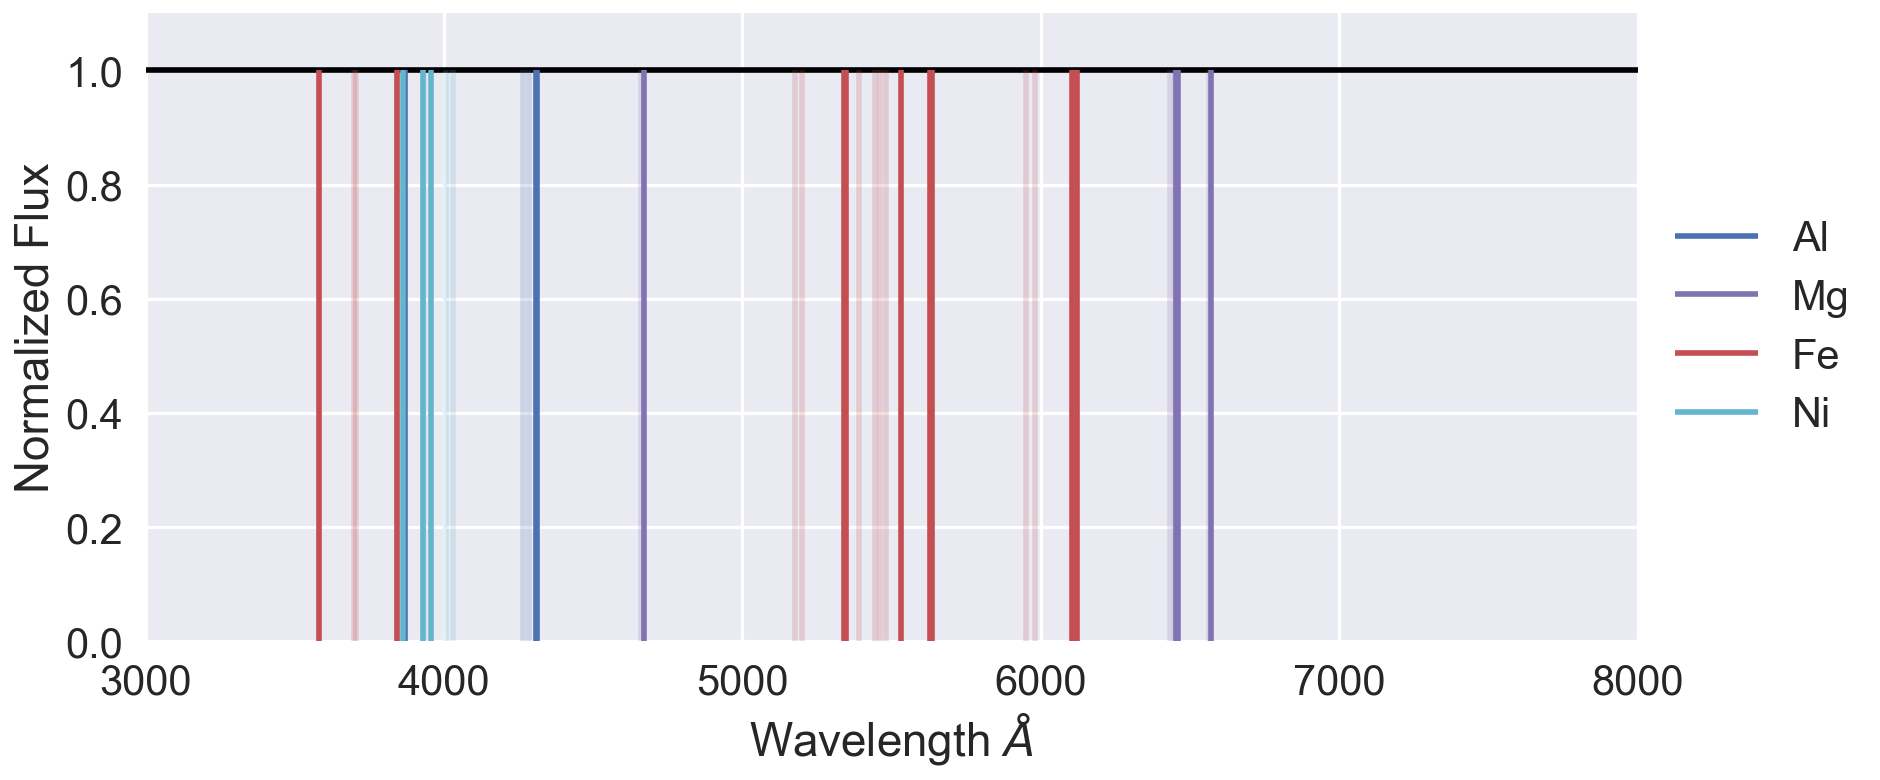

In [11]:
def plot_absorption(specie=['Al', 'Mg'],
                    z=1.3,
                    daa=0.05,
                   ):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.hlines(1, 0, 10000)
    for tran, row in qvals[qvals.index.str.startswith(tuple(specie))].iterrows():
        ax.vlines((1.0 + z) * row.wave + row.qval * ((daa + 1)**2.0-1.0), 
                      0, 1, color=plot_colors[tran[:2]])
        ax.vlines((1.0 + z) * row.wave, 
                      0, 1, color=plot_colors[tran[:2]], alpha=0.2)
        
    ax.set_xlim(3000, 8e3)
    ax.set_ylim(0, 1.1)
    ax.set_ylabel("Normalized Flux")
    ax.set_xlabel(r"Wavelength $\AA$")
    
    for spec in specie:
        ax.vlines(-1, -1, 0, color=plot_colors[spec], label=spec)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()

plot_absorption(specie=['Al', 'Mg', 'Fe', 'Ni'], )

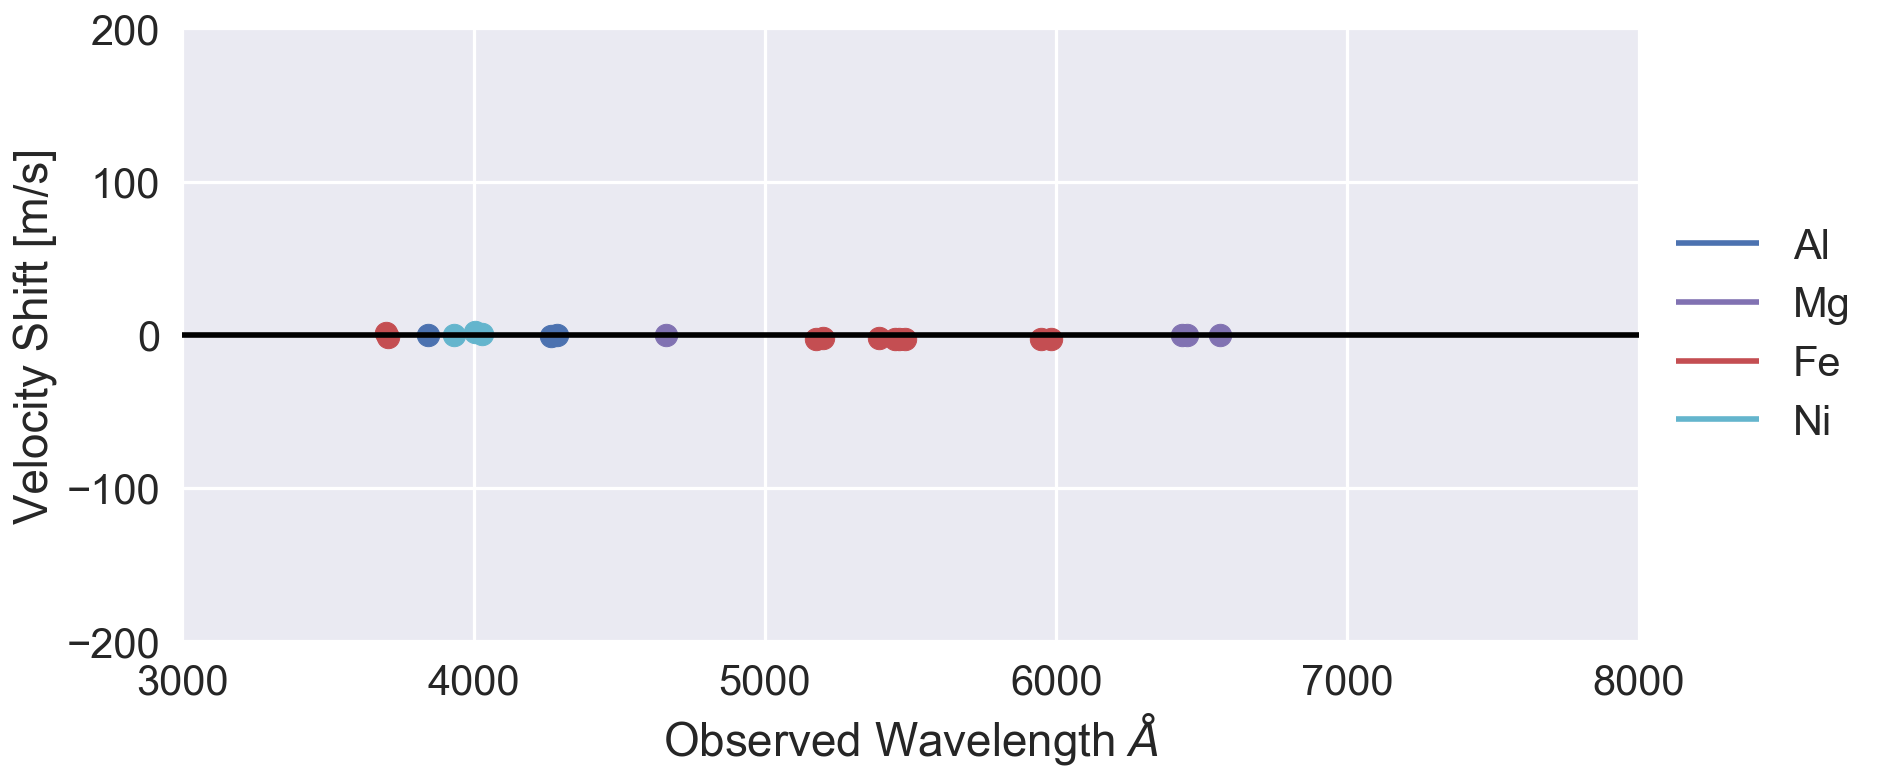

In [31]:
def plot_shift(specie=['Al', 'Mg'],
                    z=1.3,
                    daa=0.05,
                   ):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.hlines(0, 0, 10000)
    for tran, row in qvals[qvals.index.str.startswith(tuple(specie))].iterrows():
        ax.scatter((1.0 + z) * row.wave, 
#                    row.qval * ((daa + 1)**2.0-1.0),
                   shifted_velocity(daa, row.qval, (1.0 + z) * row.wave),
                   color=plot_colors[tran[:2]])
        
    ax.set_xlim(3000, 8e3)
    ax.set_ylim(-200, 200)
    ax.set_ylabel("Velocity Shift [m/s]")
    ax.set_xlabel(r"Observed Wavelength $\AA$")
    
    for spec in specie:
        ax.vlines(-1, -1, 0, color=plot_colors[spec], label=spec)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()

plot_shift(specie=['Al', 'Mg', 'Fe', 'Ni'], )

In [43]:
redshift_slider = FloatSlider(value=2.1, min=0.0, max=3.5)
alpha_slider = FloatSlider(value=0.0, min=-5.0, max=5.0, step=0.1)
species_select = SelectMultiple(options=['Al', 'Cr', 'Fe', 'Mg', 'Mn', 'Ni', 'Si'],
                                description="Species",
                                value=['Al', 'Fe']
                               )
# w = interactive(plot_absorption, 
#                 specie=species_select,
#                 z=redshift_slider,
#                 daa=alpha_slider,
#                )
shift_interactive = interactive(plot_shift, 
                specie=species_select,
                z=redshift_slider,
                daa=alpha_slider,
               )

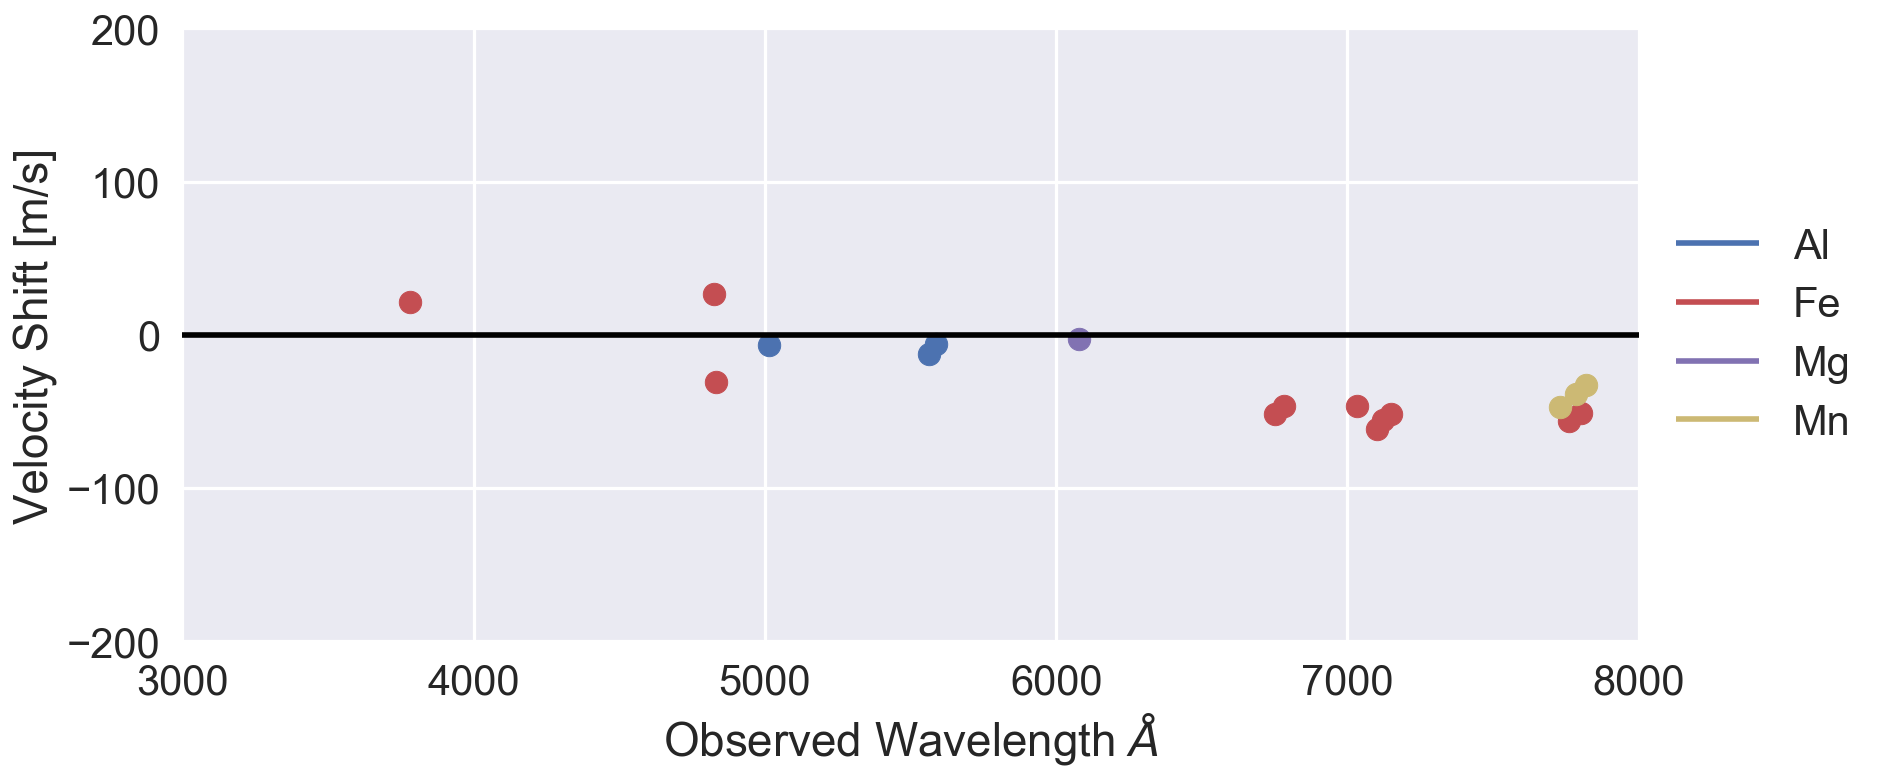

In [44]:
shift_interactive

In [42]:
full_parse.head()

,#J2000,zem,zabs,da,eda,sample,source,sigflag,imrotator,transition
0,J000149-015940,2.31,2.09510,0.34,7.27,B1,Keck,2,0,d g h i j k l s t u v w
1,J000149-015940,2.31,2.15390,36.05,39.54,B1,Keck,1,0,d f g l
2,J000322-260316,4.11,1.43420,-12.53,11.67,C,Keck,1,1,b c p r
3,J000322-260316,4.11,3.38970,-78.43,35.48,C,Keck,1,1,d g l m
4,J000520+052410,1.90,0.59137,-31.05,24.33,C,Keck,1,0,b c n p q r


In [15]:
def plot_shifts(telescope='VLT'):
    fig, ax = plt.subplots(figsize=(12, 6))
    w, s = observed_shifts(telescope=telescope)
    sns.regplot(w, s, lowess=True, scatter_kws={'alpha':0.2}, ax=ax)
    ax.set_ylim(-200, 200)
    ax.set_xlabel(r"Observed Wavelength [$\AA$]")
    ax.set_ylabel("Velocity [m/s]")
    ax.set_title(telescope)
    fig.tight_layout()

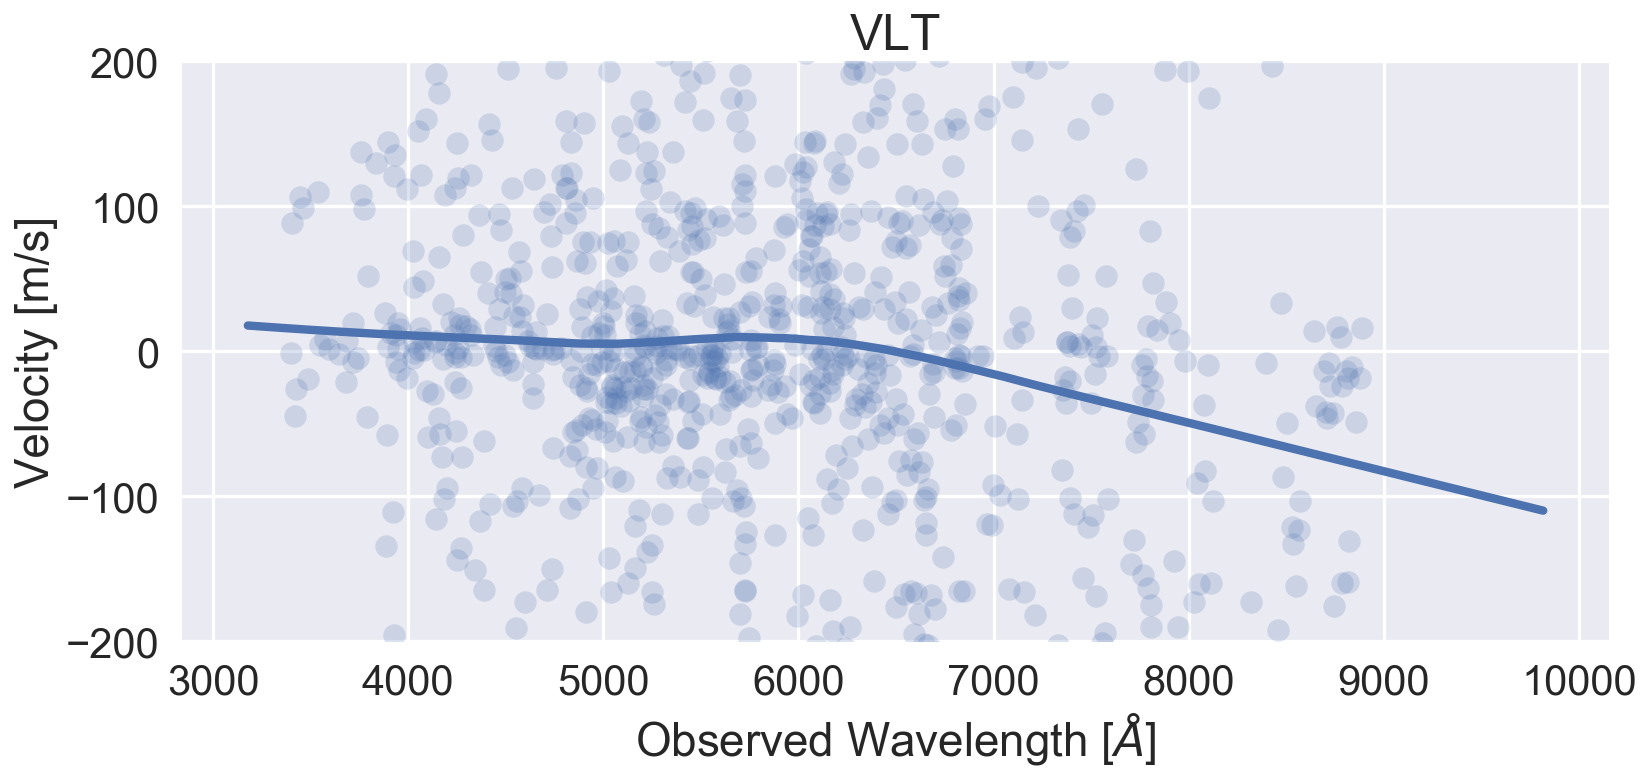

In [16]:
plot_shifts(telescope='VLT')

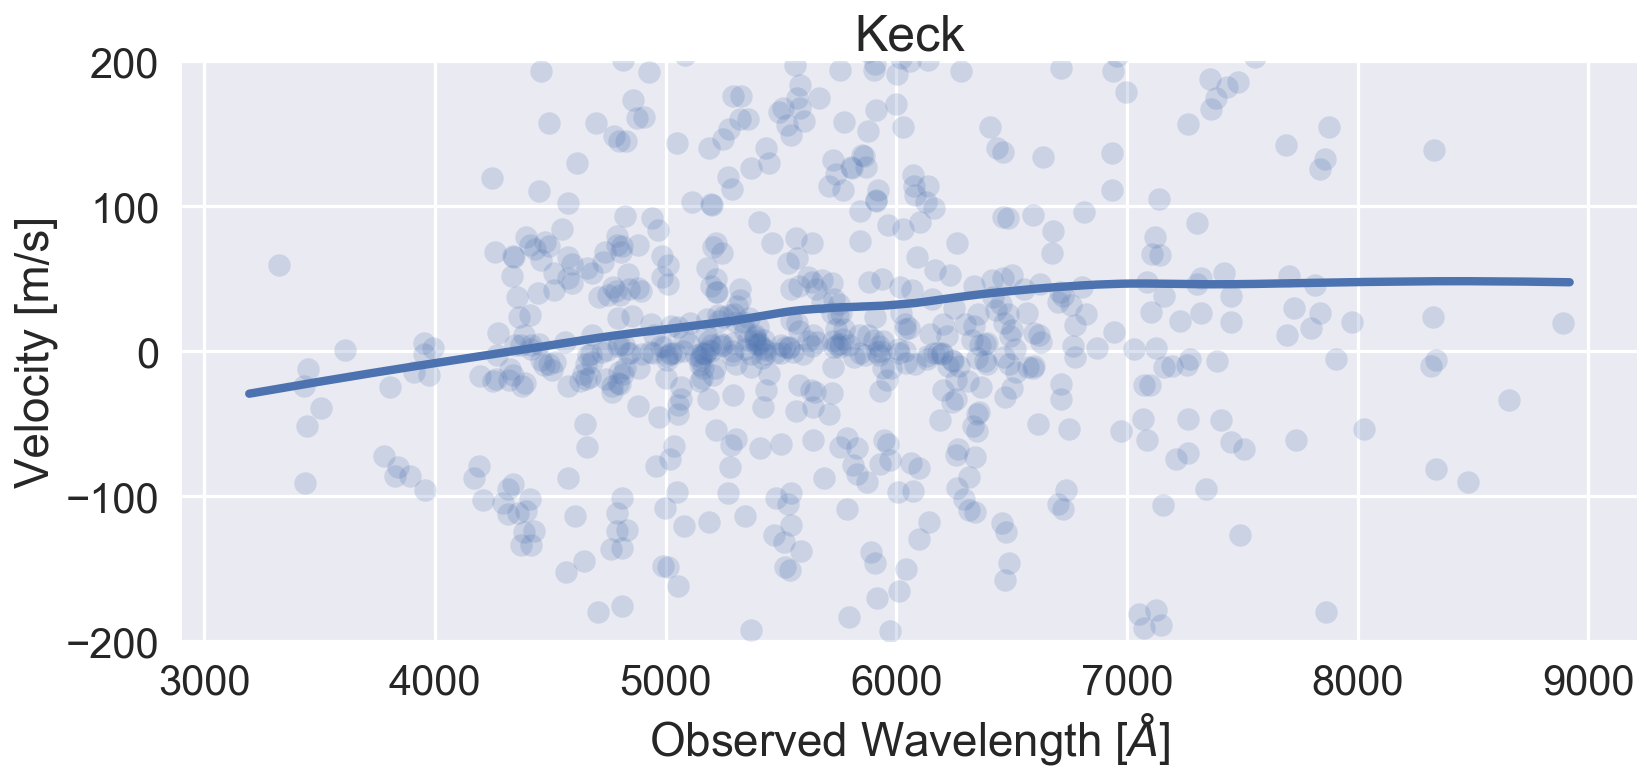

In [17]:
plot_shifts(telescope='Keck')

In [59]:
def plot_all(title='Keck + VLT'):
    fig, ax = plt.subplots(figsize=(12, 8))
    telescope='VLT'
    w, s = observed_shifts(telescope=telescope)
    sns.regplot(w, s, lowess=True, scatter_kws={'alpha':0.5}, ax=ax, label=telescope)
    telescope='Keck'
    w, s = observed_shifts(telescope=telescope)
    sns.regplot(w, s, lowess=True, scatter_kws={'alpha':0.5}, ax=ax, label=telescope)
    ax.set_xlim(2000, 10000)
    ax.set_ylim(-200, 200)
    ax.legend()
    ax.set_xlabel(r"Observed Wavelength [$\AA$]")
    ax.set_ylabel("Velocity [m/s]")
    ax.set_title(title)
    fig.tight_layout()

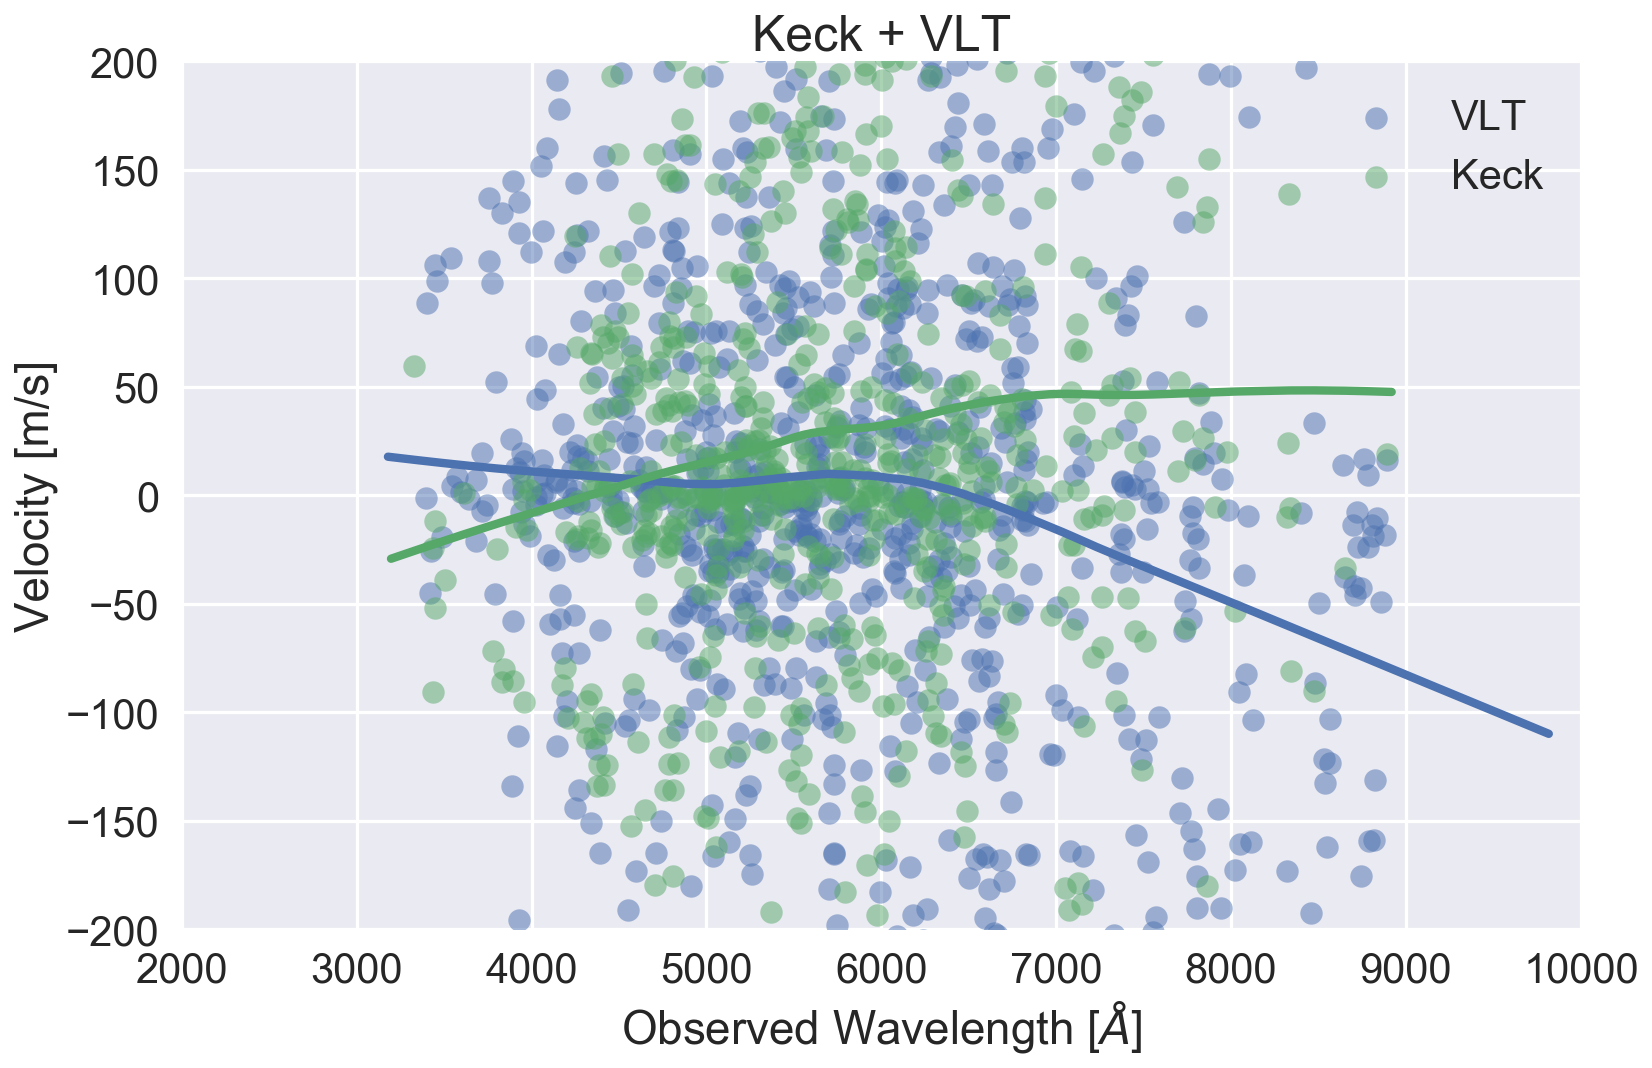

In [60]:
plot_all()

In [61]:
def observed_shifts_by_sample(sample='A'):
    waves = []
    shifts = []
    for index, row in full_parse[full_parse['sample'] == sample].iterrows():
        for tran in row['transition'].split():
            rest_wave = qvals.loc[codes.loc[tran].trans].wave
            measured_wave = rest_wave * (1 + row.zabs)
            qval = qvals.loc[codes.loc[tran].trans].qval
            waves.append(measured_wave)
            shifts.append(shifted_velocity(row.da, qval, rest_wave))
    return np.array(waves), np.array(shifts)

def plot_samples():
    fig, ax = plt.subplots(figsize=(12, 8))
    telescope='VLT'
    for sample in sorted(full_parse['sample'].unique()):
        w, s = observed_shifts_by_sample(sample=sample)
        sns.regplot(w, s, lowess=True, scatter_kws={'alpha':0.5}, ax=ax, label=sample)
    ax.set_ylim(-400, 400)
    ax.set_xlim(2000, 10000)
    ax.legend()
#     frame = ax.get_frame()
#     frame.set_alpha(1.0)
    ax.set_xlabel(r"Observed Wavelength [$\AA$]")
    ax.set_ylabel("Velocity [m/s]")
    ax.set_title('Samples')
    fig.tight_layout()

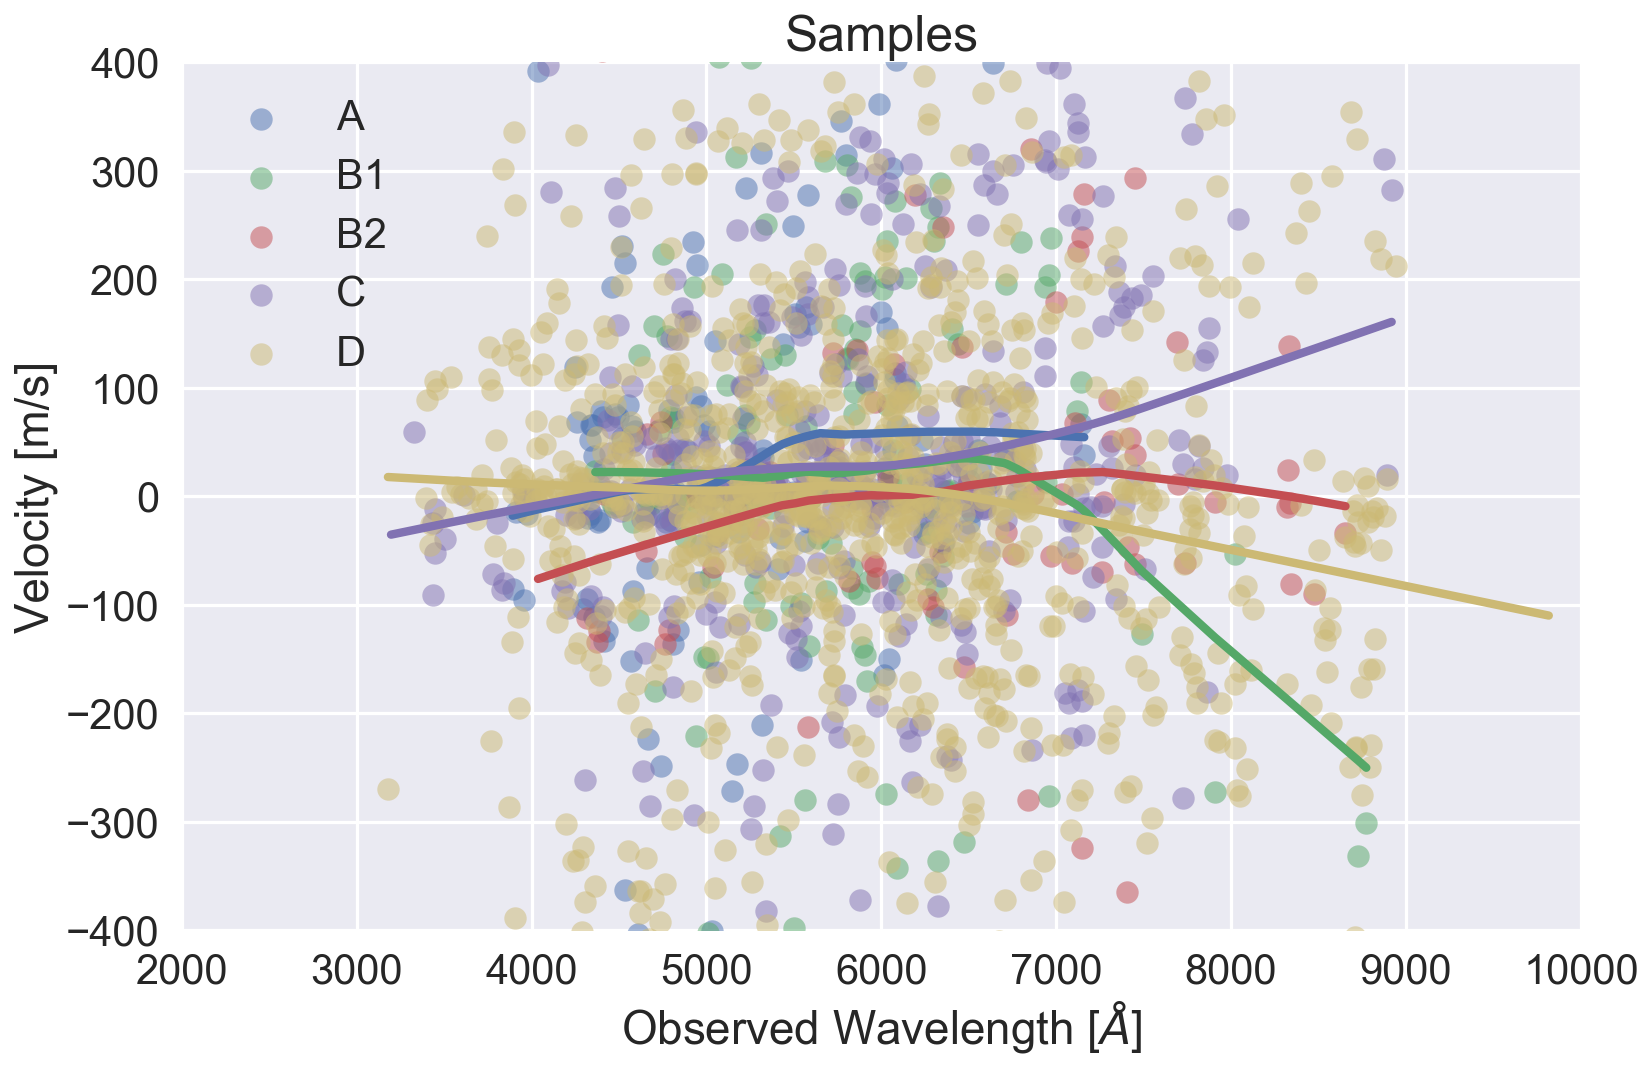

In [62]:
plot_samples()

## Simulations

Generate velocity shifts for the dipole hypothesis.

In [63]:
DIP_RA = 17.3
DIP_RA_ERR = 1.0
DIP_DEC = -61.0
DIP_DEC_ERR = 10.0
DIP_AMPLITUDE = 0.97e-5
DIP_AMPLITUDE_ERR = 0.21e-5 # average of asymmetric errors
DIP_MONOPOLE = -0.178e-5
DIP_MONOPOLE_ERR  = 0.084e-5

dipole = SkyCoord(DIP_RA, DIP_DEC, unit=(u.hourangle, u.deg))

In [64]:
def parse_j2000(name):
    return ' '.join([name[1:3], name[3:5], name[5:7], name[7:10], name[10:12], name[12:]])

In [65]:
def dipole_alpha(name):
    c = SkyCoord(parse_j2000(name), unit=(u.hourangle, u.deg))
    theta = float(c.separation(dipole).to_string(decimal=True))
    return (DIP_AMPLITUDE * np.cos(np.deg2rad(theta)) + DIP_MONOPOLE) * 1e6

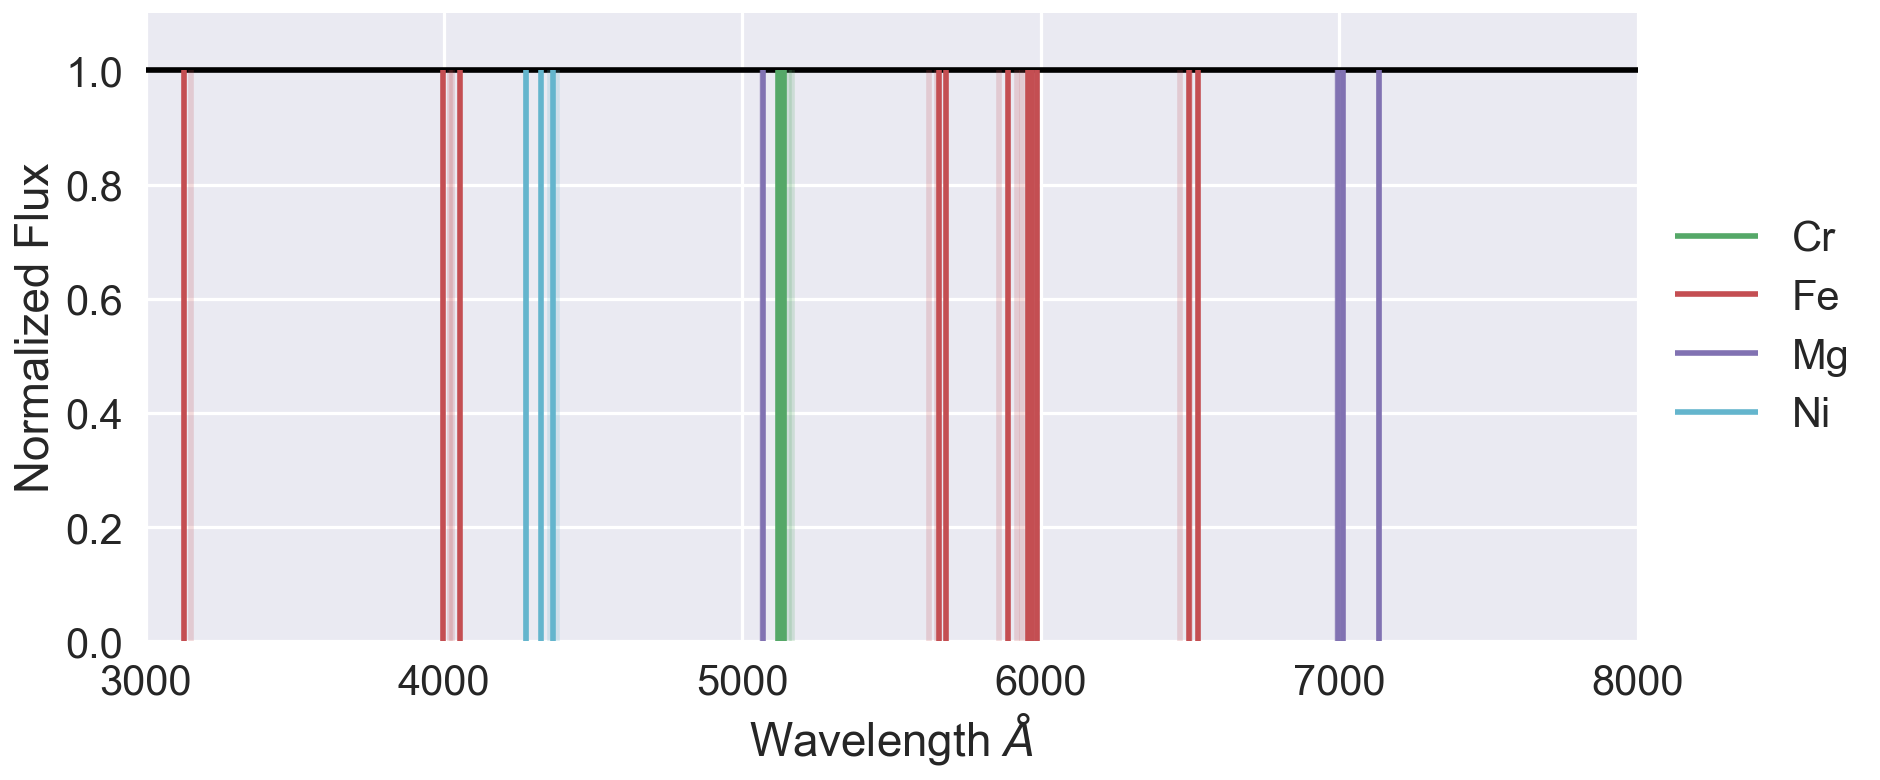

In [54]:
w

In [74]:
def plot_sim(telescope='VLT', use_dipole=True):
    fig, ax = plt.subplots(figsize=(12, 6))
    w, s = observed_shifts(telescope=telescope)
    sns.regplot(w, s, lowess=True, scatter_kws={'alpha':0.05}, ax=ax, label='Implied by Measured VLT')
    w, s = simulated_shifts(telescope=telescope, use_dipole=use_dipole)
    sns.regplot(w, s, lowess=True, scatter_kws={'alpha':0.05}, ax=ax, label='Implied by Dipole VLT')
    ax.set_ylim(-200, 200)
    ax.legend()
    ax.set_xlabel(r"Observed Wavelength [$\AA$]")
    ax.set_ylabel("Velocity [m/s]")
    ax.set_title('Simulated velocity shifts for ' + telescope)
    fig.tight_layout()

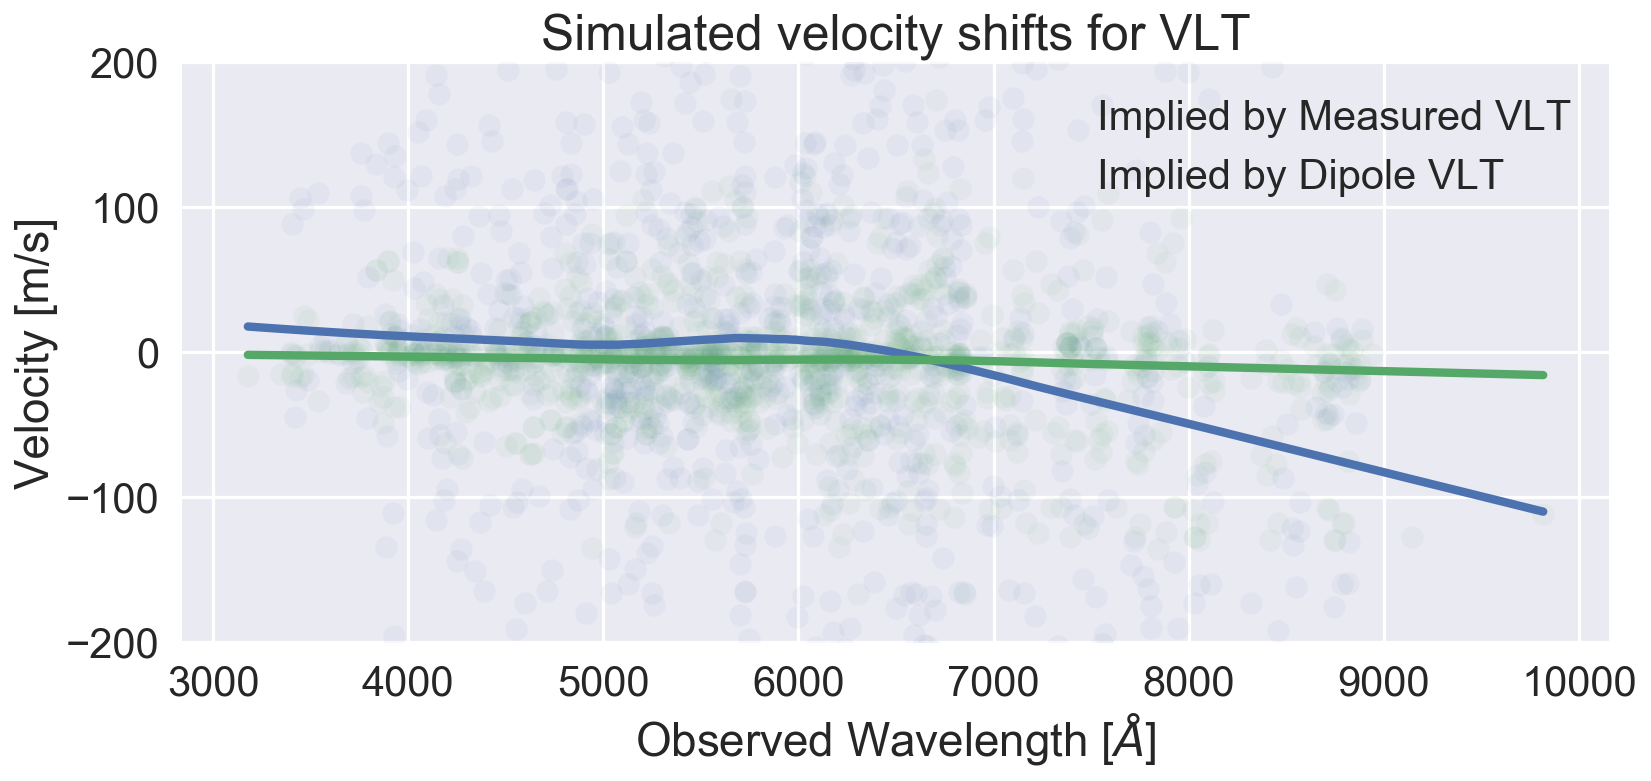

In [75]:
plot_sim()

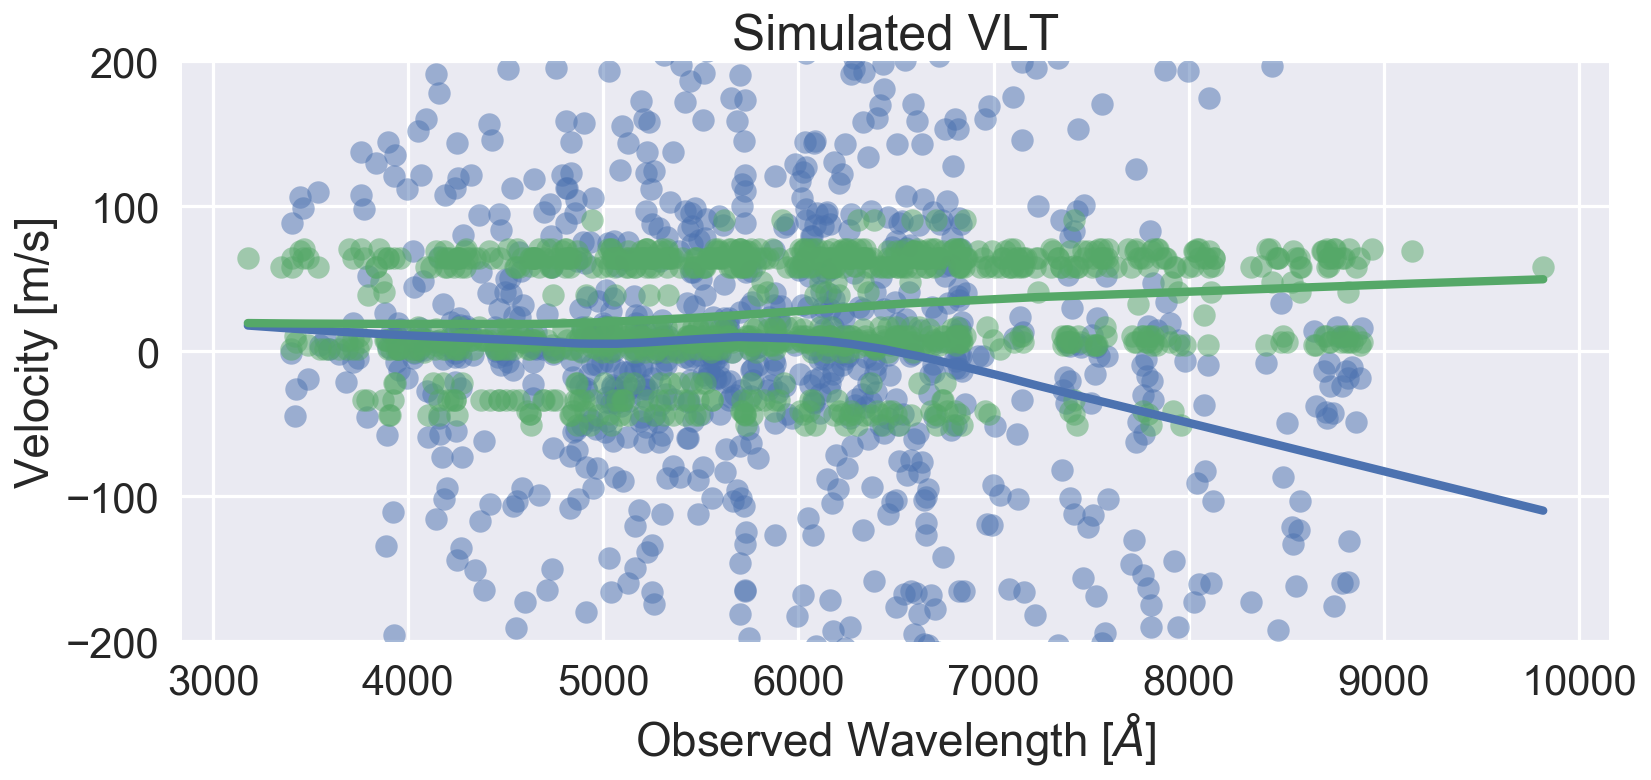

In [69]:
def simulated_shifts(telescope='VLT', use_dipole=True):
    waves = []
    shifts = []
    for index, row in full_parse[full_parse.source.eq(telescope)].iterrows():
        for tran in row['transition'].split():
            rest_wave = qvals.loc[codes.loc[tran].trans].wave
            measured_wave = rest_wave * (1 + row.zabs)
            qval = qvals.loc[codes.loc[tran].trans].qval
            waves.append(measured_wave)
#             da = row.da
            if use_dipole:
                da = dipole_alpha(row['#J2000'])
            else:
                da = -3.0
            shifts.append(shifted_velocity(da, qval, rest_wave))
    return np.array(waves), np.array(shifts)

plot_sim(use_dipole=False)

## Hypothesis test

I think that a non-parametric test for $\alpha$ would be to fit for all velocity shifts as independent shifts. 

The general procedure would be thus:

 - fit velocity shifts per wavelength region (with errors). 

,#J2000,zem,zabs,da,eda,sample,source,sigflag,imrotator,transition
152,J004131-493611,3.24,2.2485,-12.3,6.72,D,VLT,3,0,j1 j2 j3 j6 j7 j8 c1 d1 d2 e2 h1 h2 h3 l1 l2 k...


In [88]:
row['transition'].values

array(['j1 j2 j3 j6 j7 j8 c1 d1 d2 e2 h1 h2 h3 l1 l2 k1 i1 i2'], dtype=object)

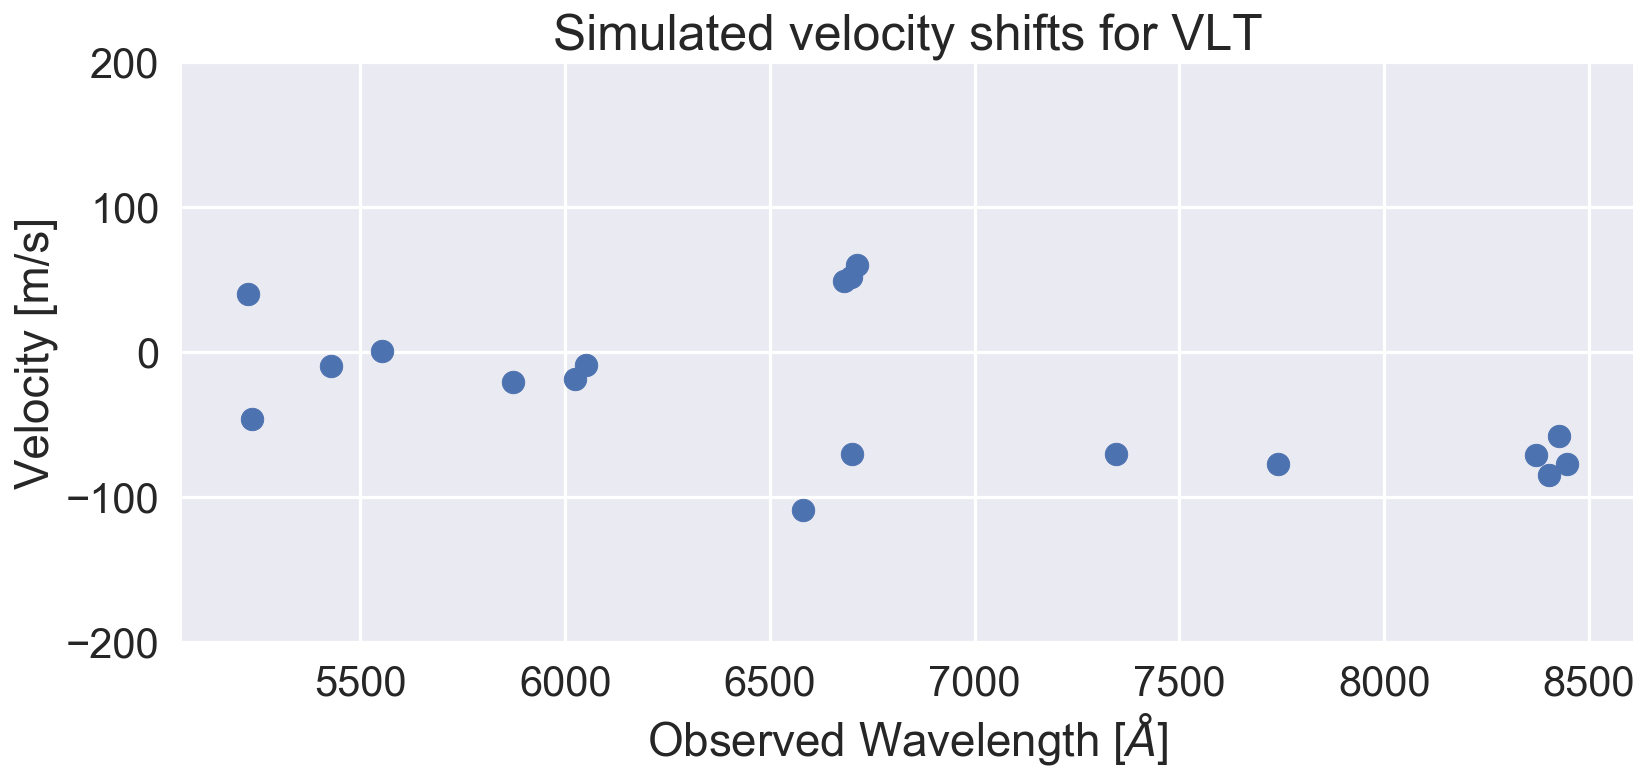

In [99]:
telescope = 'VLT'
row = full_parse[full_parse.source.eq(telescope)].sample(1,
                                                   random_state=2
                                                  ).iloc[0]
waves = []
shifts = []
for tran in row['transition'].split():
    rest_wave = qvals.loc[codes.loc[tran].trans].wave
    measured_wave = rest_wave * (1 + row.zabs)
    qval = qvals.loc[codes.loc[tran].trans].qval
    waves.append(measured_wave)
#             da = row.da
#     if use_dipole:
    da = dipole_alpha(row['#J2000'])
#     else:
#         da = -3.0
    shifts.append(shifted_velocity(da, qval, rest_wave))
wav, shift = np.array(waves), np.array(shifts)



fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(wav, shift)
ax.set_ylim(-200, 200)
# ax.legend()
ax.set_xlabel(r"Observed Wavelength [$\AA$]")
ax.set_ylabel("Velocity [m/s]")
ax.set_title('Simulated velocity shifts for ' + telescope)
fig.tight_layout()

In [ ]:
telescope = 'VLT'
row = full_parse[full_parse.source.eq(telescope)].sample(1,
                                                   random_state=2
                                                  ).iloc[0]
waves = []
shifts = []
for tran in row['transition'].split():
    rest_wave = qvals.loc[codes.loc[tran].trans].wave
    measured_wave = rest_wave * (1 + row.zabs)
    qval = qvals.loc[codes.loc[tran].trans].qval
    waves.append(measured_wave)
#             da = row.da
#     if use_dipole:
    da = dipole_alpha(row['#J2000'])
#     else:
#         da = -3.0
    shifts.append(shifted_velocity(da, qval, rest_wave))
wav, shift = np.array(waves), np.array(shifts)



fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(wav, shift)
ax.set_ylim(-200, 200)
# ax.legend()
ax.set_xlabel(r"Observed Wavelength [$\AA$]")
ax.set_ylabel("Velocity [m/s]")
ax.set_title('Simulated velocity shifts for ' + telescope + " " + str(np.round(da, 2)))
fig.tight_layout()

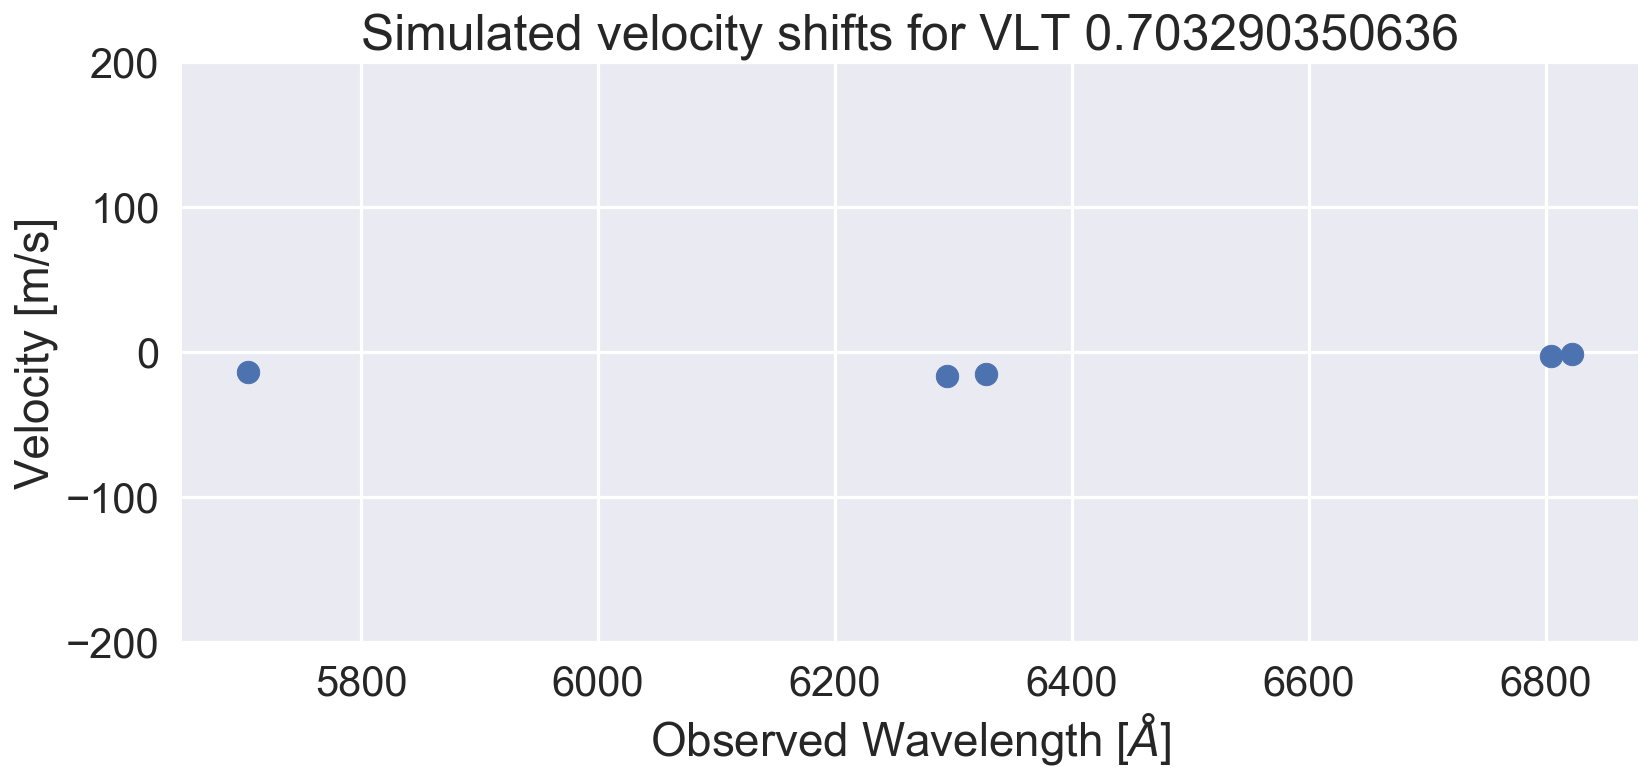

In [113]:
telescope = 'VLT'
row = full_parse[full_parse.source.eq(telescope)].sample(1,
                                                   random_state=3
                                                  ).iloc[0]
waves = []
shifts = []
for tran in row['transition'].split():
    rest_wave = qvals.loc[codes.loc[tran].trans].wave
    measured_wave = rest_wave * (1 + row.zabs)
    qval = qvals.loc[codes.loc[tran].trans].qval
    waves.append(measured_wave)
#             da = row.da
#     if use_dipole:
    da = dipole_alpha(row['#J2000'])
#     else:
#         da = -3.0
    shifts.append(shifted_velocity(da, qval, rest_wave))
wav, shift = np.array(waves), np.array(shifts)



fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(wav, shift)
ax.set_ylim(-200, 200)
# ax.legend()
ax.set_xlabel(r"Observed Wavelength [$\AA$]")
ax.set_ylabel("Velocity [m/s]")
ax.set_title('Simulated velocity shifts for ' + telescope + " " + str(da))
fig.tight_layout()

In [ ]:
dipole_alpha()

-12.300000000000001

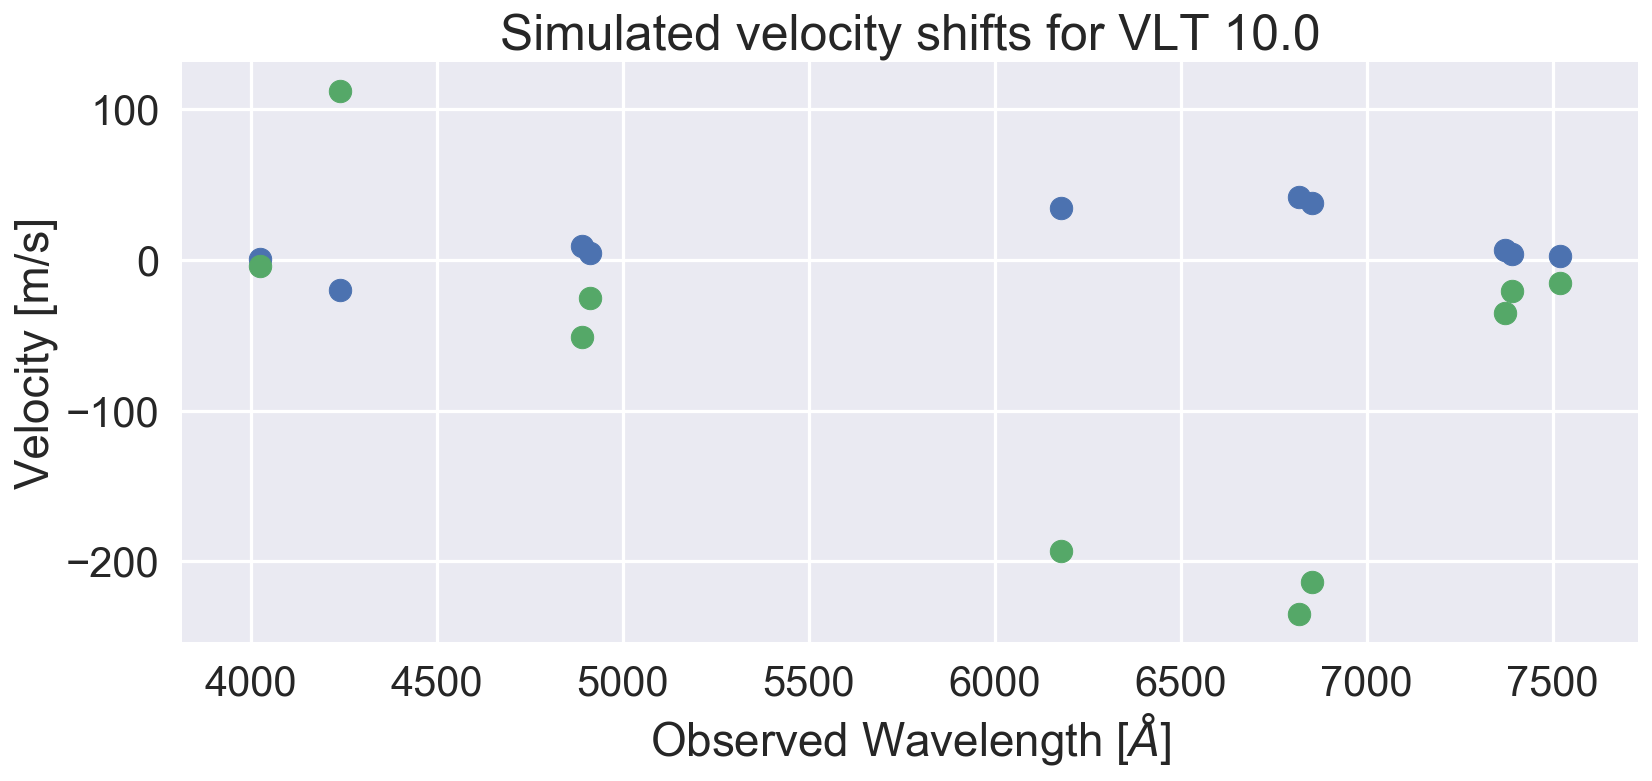

In [112]:
telescope = 'VLT'
row = full_parse[full_parse.source.eq(telescope)].sample(1,
                                                   random_state=8
                                                  ).iloc[0]
waves = []
shifts = []
for tran in row['transition'].split():
    rest_wave = qvals.loc[codes.loc[tran].trans].wave
    measured_wave = rest_wave * (1 + row.zabs)
    qval = qvals.loc[codes.loc[tran].trans].qval
    waves.append(measured_wave)
#             da = row.da
#     if use_dipole:
    da = dipole_alpha(row['#J2000'])
#     else:
#         da = -3.0
    shifts.append(shifted_velocity(da, qval, rest_wave))
wav, shift = np.array(waves), np.array(shifts)

# row.da

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(wav, shift)

waves = []
shifts = []
for tran in row['transition'].split():
    rest_wave = qvals.loc[codes.loc[tran].trans].wave
    measured_wave = rest_wave * (1 + row.zabs)
    qval = qvals.loc[codes.loc[tran].trans].qval
    waves.append(measured_wave)
#             da = row.da
#     if use_dipole:
    da = row.da
#     else:
#         da = -3.0
    shifts.append(shifted_velocity(da, qval, rest_wave))
wav, shift = np.array(waves), np.array(shifts)

ax.scatter(wav, shift)




# ax.set_ylim(-200, 200)
# ax.legend()
ax.set_xlabel(r"Observed Wavelength [$\AA$]")
ax.set_ylabel("Velocity [m/s]")
ax.set_title('Simulated velocity shifts for ' + telescope + " " + str(da))
fig.tight_layout()